In [1]:
%%capture
!pip install pyspark

In [27]:
import pandas as pd
import pyspark.sql.functions as f
import pyspark.sql.types as t

from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import VectorAssembler,Imputer, MinMaxScaler
from pyspark.ml.stat import Correlation
from typing import List, Optional

from google.colab import drive
drive.mount('/content/gdrive')

pd.set_option("display.max_rows", 500)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
spark = (
    SparkSession
    .builder
    .appName("app")
    .config("spark.driver.memory", "12g")
    .getOrCreate()
)

sc = spark.sparkContext
spark.sparkContext.setLogLevel("WARN")

Задача - по информации о блюде определить, является ли оно десертом

In [7]:
food = (
    spark.read.csv(
        '/content/gdrive/MyDrive/Colab Notebooks/pyspark/ch12/files/epi_r.csv',
        header=True
    )
)
print(food.count(), len(food.columns))
food.select(food.columns[:10]).printSchema()

20057 680
root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: string (nullable = true)
 |-- fat: string (nullable = true)
 |-- sodium: string (nullable = true)
 |-- #cakeweek: string (nullable = true)
 |-- #wasteless: string (nullable = true)
 |-- 22-minute meals: string (nullable = true)
 |-- 3-ingredient recipes: string (nullable = true)



некоторые названия колонок содержат неизвестны символы, пробелы, начинаются с #

In [8]:
def sanitize_column_name(name):
    """Drops unwanted characters from the column name.
    We replace spaces, dashes and slashes with underscore,
    and only keep alphanumeric characters."""
    answer = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_"), ("&", "and")):
        answer = answer.replace(i, j)
    return "".join(
        [
            char
            for char in answer
            if char.isalpha() or char.isdigit() or char == "_"
        ]
    )

food = food.toDF(*[sanitize_column_name(name) for name in food.columns])

вывод сводной информации о столбцах

ищем бинарные столбцы
collect_set содержит список уникальных элементов, поэтому если его размер равен 2, то колонка бинарная.  
чтобы превратить строки в столбцы для более удобного анализа, нужно пременить операцию un-pivot, самый легкий способ - сделать это в pandas

In [9]:
is_binary = food.select(
    [
        (f.size(f.collect_set(x)) == 2).alias(x)
        for x in food.columns
    ]
)
is_binary.show()
is_binary = is_binary.toPandas()
is_binary.unstack().value_counts()

+-----+------+--------+-------+-----+------+--------+---------+---------------+--------------------+--------------------+---------------------+-------+------+---------+------+--------+-------+-----+-----------+----------------+--------+---------+-----+-----------+-------+-------+---------+-------+----------+---------+-----+-------+---------+-------+--------------+------------+-----+----+------+------+-----+----+------------+----+----+--------+----------+---------------+----+----+-----------+-----+-------------+--------+-------+-------+----------+-------+-----------+---------+----+--------+-----------+----------+------+-------+------+----+------+-----+-----------+---------+----+-----+-------+--------+-------------+-----+--------+----------+-------+------+--------------+-------+------+--------+------+-------+------+----------+----------------+--------------------+-------+----+----------+--------+---------+-------+-------+------+-----+-----------------+----------+------+-------+--------+-

True     672
False      8
dtype: int64

при выводе summary колонки cakeweek, wasteless оказались подозрительными, проверяем их

In [10]:
food.select(
    [f.collect_set(x) for x in ('cakeweek','wasteless')]
).show(truncate=False)

(
    food
    .select('cakeweek', 'wasteless')
    .filter(
        (f.col('cakeweek')>1)
        | (f.col('wasteless')>1)
    )
).show()

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1188.0, 880.0, 24.0, 1.0]|[0.0, 1.0, 1439.0]    |
+-------------------------------+----------------------+

+--------+---------+
|cakeweek|wasteless|
+--------+---------+
|   880.0|      0.0|
|    24.0|   1439.0|
|  1188.0|      0.0|
+--------+---------+



эти выбросы могут быть связаны либо с самими данными, либо с ошибкой чтения csv. Удаляем их, пропуски оставляем

In [11]:
food = food.filter(
    (
        (f.col('cakeweek') <= 1)
        | (f.col('cakeweek').isNull())
    )
    & (
        (f.col('wasteless') <= 1)
        | (f.col('wasteless').isNull())
    )
)

константы, содержащие названия колонок

In [12]:
IDENTIFIERS = ["title"]
CONTINUOUS_COLUMNS = [
    "rating",
    "calories",
    "protein",
    "fat",
    "sodium",
]
TARGET_COLUMN = ["dessert"]
BINARY_COLUMNS = [
    x
    for x in food.columns
    if x not in CONTINUOUS_COLUMNS
    and x not in TARGET_COLUMN
    and x not in IDENTIFIERS
]

мы знаем, что бинарные столбцы содержат только 2 значения - 0 или 1, поэтому можем перевести их в правильный тип данных.

In [13]:
# BINARY_COLUMNS = BINARY_COLUMNS[:20]
food = (
    food
    .select(
        *IDENTIFIERS,
        *[f.col(col).cast('float') for col in TARGET_COLUMN + BINARY_COLUMNS],
        *CONTINUOUS_COLUMNS
    )
)

удаляем строки с пропущенным значением во всех колонках кроме идентификатора или с пропущенным значением в таргете

In [14]:
food = food.dropna(
    how="all",
    subset=[x for x in food.columns if x not in IDENTIFIERS],
)
food = food.dropna(subset=TARGET_COLUMN)
print(food.count(), len(food.columns))

20049 680


пропуски в бинарных колонках заменяем нулем

In [15]:
food = food.na.fill(0, subset=BINARY_COLUMNS)
print(food.filter(f.col(BINARY_COLUMNS[0]).isNull()).count())

0


проверяем, числовые ли CONTINUOUS_COLUMNS. из-за невыровненного csv испортились колонки rating и calories

In [16]:
@f.udf(t.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    return True

(
    food
    .filter(~is_a_number(f.col("rating")))
    .select(CONTINUOUS_COLUMNS)
).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|NULL|  NULL|
+---------+------------+-------+----+------+



удаляем строковые значения и меняем тип колонок  
если метод cast не может преобразовать элемент во float, то он заменит его null  


вариант решения в комментариях - вариант из книги, но так как он работает очень долго, было решено упростить код, убрав операцию фильтрации

In [17]:
food = (
    food
    .select(
        *IDENTIFIERS,
        *BINARY_COLUMNS,
        *[f.col(col).cast(t.DoubleType()) for col in CONTINUOUS_COLUMNS]
    )
)


анализируем статистику числовых колонок

In [18]:
(
    food
    .select(*CONTINUOUS_COLUMNS)
    .summary(
        "mean",
        "stddev",
        "min",
        "1%",
        "5%",
        "50%",
        "95%",
        "99%",
        "max"
    )
).show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|            rating|          calories|           protein|               fat|           sodium|
+-------+------------------+------------------+------------------+------------------+-----------------+
|   mean| 3.714460295291301|6324.0634571930705|100.16778386203424| 346.9398083953107|6226.927244193346|
| stddev|1.3409187660508972| 359079.8369634022|3840.5601964520074|20458.040344124118|333349.5680370267|
|    min|               0.0|               0.0|               0.0|               0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|               0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|               0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|              17.0|            294.0|
|    95%|               5.0|            1316.0|              75.

видим, что в этих колонках есть экстримально большие значения.  
захардкодим ограничение колонок 99 квантилем.  
f.least - функция, которая возвращает минимальное значение из 2х колонок. то есть если значение будет больше 99 квантиля, то мы вернем 99 квантиль.


In [19]:
maximum = {
    "calories": 3203.0,
    "protein": 173.0,
    "fat": 207.0,
    "sodium": 5661.0,
}
for k, v in maximum.items():
    food = food.withColumn(
        k,
        f.when(
            f.isnull(f.col(k)), f.col(k)
        )
        .otherwise(
            f.least(f.col(k), f.lit(v))
        ),
    )

удаляем бинарные колонки из списка BINARY_COLUMNS, где нолей или едениц меньше 10.  
метод head выводит первую строку df. после методы asdict получаем словарь, где ключ - название колонки, а значение - сумма единиц в ней  


In [21]:
inst_sum_of_binary_columns = [
    f.sum(f.col(x)).alias(x) for x in BINARY_COLUMNS
]

sum_of_binary_columns = (
    food.select(*inst_sum_of_binary_columns).head().asDict()
)

num_rows = food.count()
too_rare_features = [
    k
    for k, v in sum_of_binary_columns.items()
    if v < 10 or v > (num_rows - 10)
]

print(len(too_rare_features))

BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))


167


генерируем 2 колонки: fat_ratio, protein_ratio

In [22]:
food = food.withColumn(
    "protein_ratio", f.col("protein") * 4 / f.col("calories")
).withColumn(
    "fat_ratio", f.col("fat") * 9 / f.col("calories")
)
food = food.fillna(0.0, subset=["protein_ratio", "fat_ratio"])
CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

удаляем мультиколлениарность
VectorAssembler - объект трансформатор, который преобразует несколько столбцов в один векторный столбец, который добавляется к исходному df. Это нужно для ml моделей, где входные данные требуются в виде вектора

In [23]:
continuous_features = VectorAssembler(
    inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features"
)

print(continuous_features)

vector_food = food.select(CONTINUOUS_COLUMNS)

for x in CONTINUOUS_COLUMNS:
    vector_food = vector_food.filter(~f.isnull(f.col(x)))

vector_variable = continuous_features.transform(vector_food)
vector_variable.show(3, False)

VectorAssembler_f8a8b8e8231d
+------+--------+-------+----+------+-------------------+-------------------+---------------------------------------------------------------------+
|rating|calories|protein|fat |sodium|protein_ratio      |fat_ratio          |continuous_features                                                  |
+------+--------+-------+----+------+-------------------+-------------------+---------------------------------------------------------------------+
|2.5   |426.0   |30.0   |7.0 |559.0 |0.28169014084507044|0.14788732394366197|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|4.375 |403.0   |18.0   |23.0|1439.0|0.17866004962779156|0.5136476426799007 |[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|3.75  |165.0   |6.0    |7.0 |165.0 |0.14545454545454545|0.38181818181818183|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
+------+--------+-------+----+------+-------------------+-------------------+------

получаем матрицу корреляций  
Correlation.corr генерирует df с одной колонкой и одним столбцом, содержащим корреляционную матрицу, которую делее преобразуем в np массив и создаем pandas df  
в pyspark типы данных matrix и vektor - замаскированные массивы np

In [25]:
correlation = Correlation.corr(
    vector_variable, "continuous_features"
)
correlation.printSchema()

correlation_array = correlation.head()[0].toArray()
correlation_pd = pd.DataFrame(
    correlation_array,
    index=CONTINUOUS_COLUMNS,
    columns=CONTINUOUS_COLUMNS,
)
print(correlation_pd.iloc[:, :4])

root
 |-- pearson(continuous_features): matrix (nullable = false)

                 rating  calories   protein       fat
rating         1.000000  0.102257  0.113292  0.111536
calories       0.102257  1.000000  0.757837  0.918052
protein        0.113292  0.757837  1.000000  0.664899
fat            0.111536  0.918052  0.664899  1.000000
sodium         0.065225  0.516818  0.585450  0.421920
protein_ratio  0.094429  0.164735  0.600182  0.125572
fat_ratio      0.129946  0.176823  0.109188  0.424986


трансформаторы и эстиматоры

работу трансформеров можно заменить работой обычной ф-ии.  
разница в том, что ф-ия применяется к df с определенными параметрами и выводит преобразованный df  
при создании экземпляра трансформера мы предоставляем параметры, необходимые для его применения, но не сам df. Далее мы используем метод transform для фрейма данных, чтобы получить преобразованный df  
данный подход позволяет облегчить ml эксперементы и переносимость модели

эстиматор - объект, который генерирует объект трансформатора в зависимости от входных данных с помощью метода fit  
схема работы эстиматора

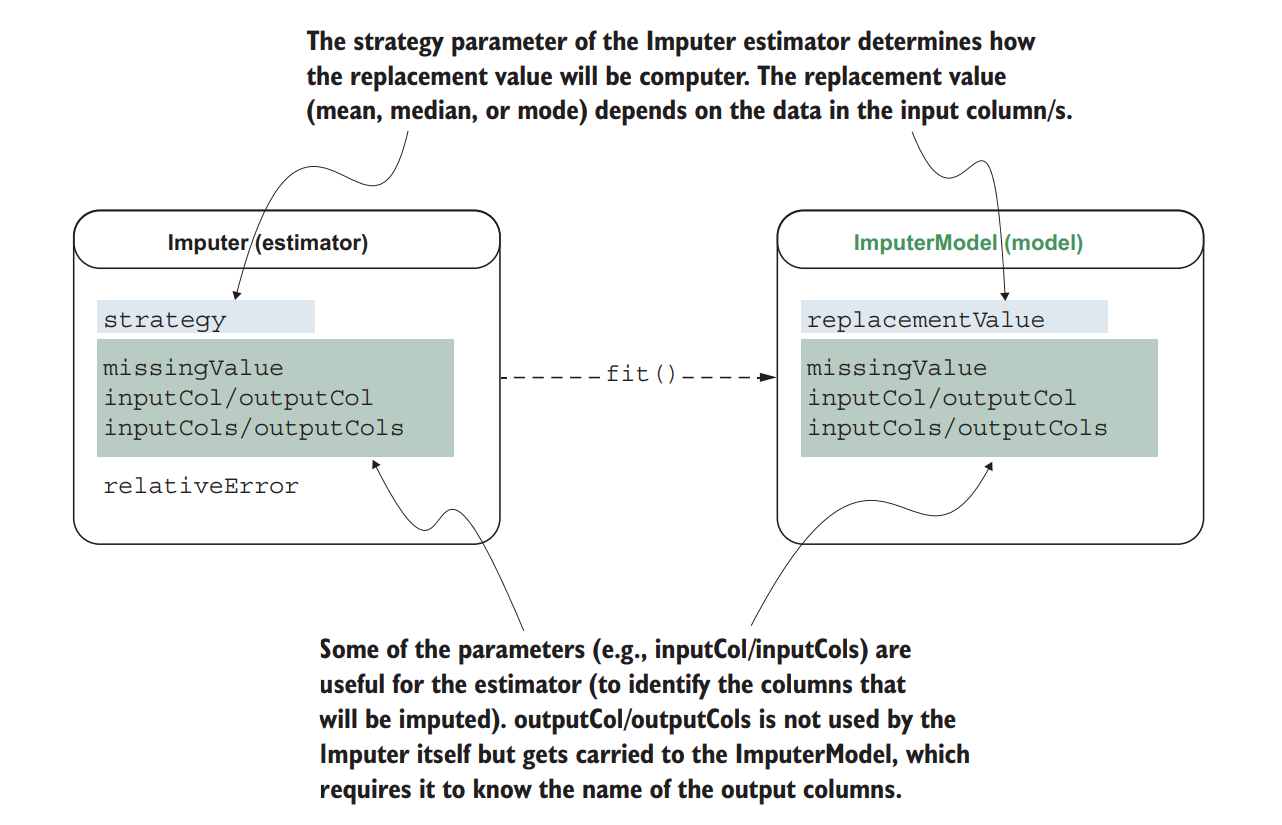

заменяем пропущенные значения в числовых колонках средним значением  
imputer_model - модель, обученная на наших данных (она знает стратегию заполнения, названия старых колонок, названия новых колонок)



In [49]:
OLD_COLS = ["calories", "protein", "fat", "sodium"]
NEW_COLS = ["calories_i", "protein_i", "fat_i", "sodium_i"]

imputer = Imputer(
    strategy="mean",
    inputCols=OLD_COLS,
    outputCols=NEW_COLS,
)
print(imputer)

imputer_model = imputer.fit(food)
print(imputer_model)

CONTINUOUS_COLUMNS = (
    list(set(CONTINUOUS_COLUMNS) - set(OLD_COLS)) + NEW_COLS
)

food_imputed = imputer_model.transform(food)

(
    food_imputed
    .filter("calories is null")
    .select("calories", "calories_i")
).show(5, False)

Imputer_21794b36a73e
ImputerModel: uid=Imputer_21794b36a73e, strategy=mean, missingValue=NaN, numInputCols=4, numOutputCols=4
+--------+-----------------+
|calories|calories_i       |
+--------+-----------------+
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
|NULL    |475.5222194325885|
+--------+-----------------+
only showing top 5 rows



масштабирование с помощью MinMaxScaler  
При использовании линейной модели масштабирование объектов означает, что коэффициенты вашей модели (вес каждого объекта) сопоставимы. Это значительно повышает интерпретируемость модели, что является полезным преимуществом при оценке производительности модели.  
MinMaxScaler требует на вход колонку в виде вектора, поэтому создаем ее с помощью VectorAssembler

схема работы MinMaxScaler  
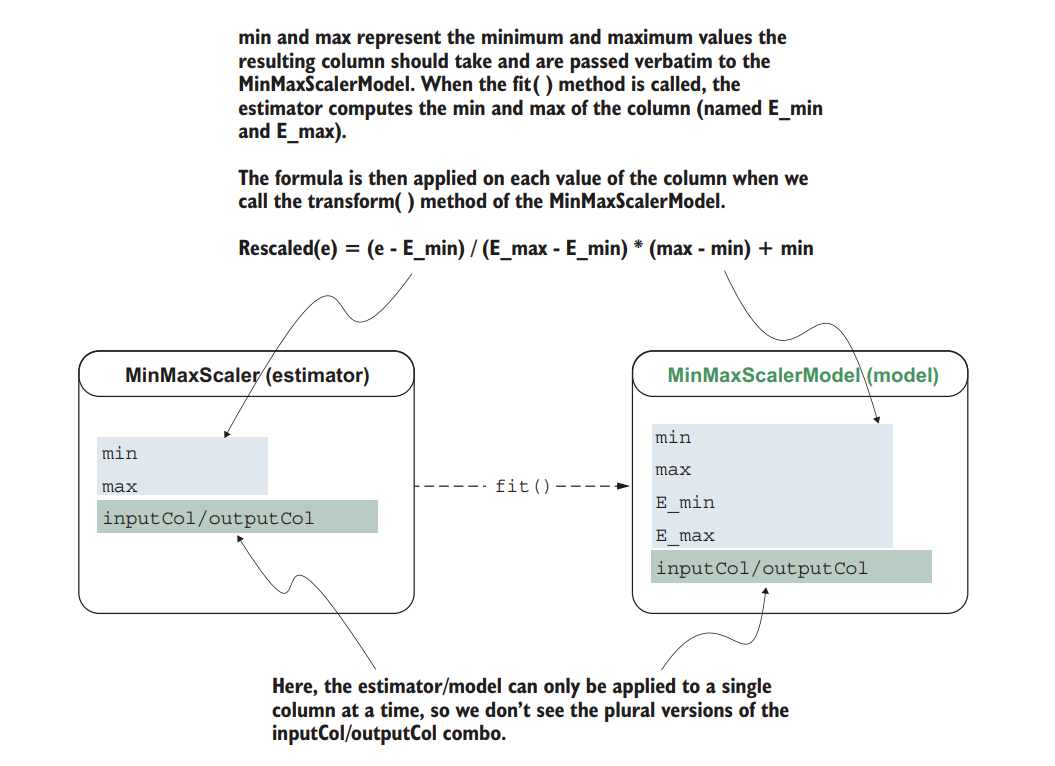

In [55]:
CONTINUOUS_NB = [x for x in CONTINUOUS_COLUMNS if ('ratio' not in x) and x != 'rating']

continuous_assembler = VectorAssembler(
    inputCols=CONTINUOUS_NB, outputCol="continuous"
)
food_features = continuous_assembler.transform(food_imputed)

continuous_scaler = MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

food_features = (
    continuous_scaler
    .fit(food_features).transform(food_features)
)
food_features.select("continuous_scaled").show(3, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|continuous_scaled                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.17341040462427745,0.13300031220730565,0.09874580462815757,0.033816425120772944,0.13300031220730565,0.17341040462427745,0.033816425120772944,0.09874580462815757]    |
|[0.10404624277456646,0.12581954417733376,0.2541953718424307,0.1111111111111111,0.12581954417733376,0.10404624277456646,0.1111111111111111,0.2541953718424307]          |
|[0.03468208092485549,0.051514205432407124,0.029146793852676208,0.033816425120772944,0.051514205432407124,0.03468208092485549,0.033816425120772944,0.0